### IU Sketch Baseline 코드  
 - python모듈 설치 코드는 처음 한번 실행해주세요.     


In [25]:
# !pip install imageio
# !pip install imageio --upgrade
# !pip install einops

In [26]:
# 모듈 path 설정.
import os,sys
sys.path.insert(1, os.path.join(os.getcwd()  , '..'))

베이스 라인 코드.  

In [27]:
import os, glob, random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import ThresholdedReLU


import config_env as cfg

from classes.image_frame import ImgFrame
from classes.video_clip import VideoClip
from models.dataset_generator import DataSetGenerator
# from models.layer_conv import Conv2Plus1D, TConv2Plus1D
# from models.layer_encoder import Encoder5D, Decoder5D
# from models.layer_lstm import ConvLstmSeries

In [28]:
# 필요한 디렉토리 없으면 생성.

# 학습용 raw_clip(gif) 파일 위치.
if not os.path.exists(cfg.RAW_CLIP_PATH):
    os.mkdir(cfg.RAW_CLIP_PATH)

# 모델 저장 위치
if not os.path.exists(cfg.MODEL_SAVE_PATH):
    os.mkdir(cfg.MODEL_SAVE_PATH)

# 임시 데이터 저장 위치
if not os.path.exists(cfg.TEMP_DATA_PATH):
    os.mkdir(cfg.TEMP_DATA_PATH)

In [29]:
class Conv2Plus1D(keras.Model):
    '''
        5-rank Spatial Convolution
    '''
    def __init__(self, filters, kernel_size, stride, padding):
        """
            (b, t, h, w, c) -> (b, t, h/stride, w/stride, f)
            A sequence of convolutional layers that first apply the convolution operation over the
            spatial dimensions, and then the temporal dimension. 
        """
        super(Conv2Plus1D, self).__init__()

        # Spatial decomposition
        self.conv1 = layers.Conv3D(filters=filters,
                    kernel_size=(1, kernel_size[1], kernel_size[2]),
                    strides=(1, stride, stride),
                    padding=padding)

        # Temporal decomposition
        self.conv2 = layers.Conv3D(filters=filters,
                        kernel_size=(kernel_size[0], 1, 1),
                        strides=1,
                        padding=padding)

        self.bn = layers.BatchNormalization()
        self.relu = layers.ReLU()

    def call(self, x):
        x = self.conv1(x)
        # x = self.conv2(x)
        # x = self.bn(x)
        # x = self.relu(x)
        return x


class TConv2Plus1D(keras.Model):
    '''
        5-rank Spatial TransposeConvolution
    '''
    def __init__(self, filters, kernel_size, stride, padding):
        """
            (b, t, h, w, c) -> (b, t, h*stride, w*stride, f)
            A sequence of convolutional layers that first apply the convolution operation over the
            spatial dimensions, and then the temporal dimension. 
        """
        super(TConv2Plus1D, self).__init__()

        # Spatial decomposition
        self.tconv1 = layers.Conv3DTranspose(filters=filters,
                    kernel_size=(1, kernel_size[1], kernel_size[2]),
                    strides=(1, stride, stride),
                    padding=padding)

        # Temporal decomposition
        self.tconv2 = layers.Conv3DTranspose(filters=filters, 
                    kernel_size=(kernel_size[0], 1, 1),
                    strides=1,
                    padding=padding)

        self.bn = layers.BatchNormalization()
        self.relu = layers.ReLU()

    def call(self, x):
        x = self.tconv1(x)
        # x = self.tconv2(x)
        # x = self.bn(x)
        # x = self.relu(x)
        return x


In [30]:

class Encoder5D(keras.Model):
    '''
        5-rank Encoder
    '''
    def __init__(self, kernel_count, filters, kernel_size, stride, padding, out_channel=None):
        """
            conv : (b, t, h, w, c) -> (b, t, h/stride, w/stride, f)
            kernel_count만큼 반복.
        """
        super(Encoder5D, self).__init__()
        self.kernel_count = kernel_count
        self.out_channel = out_channel
        self.convs = []
        self.bns = []
        self.relus = []
        
        for cnt in range(kernel_count):
            if stride == 1:
                filter_cnt = filters // (2**cnt)
            else:
                filter_cnt = filters*2**cnt
            self.convs.append(Conv2Plus1D(filter_cnt, kernel_size, stride, padding))
            self.bns.append(layers.BatchNormalization())
            self.relus.append(layers.ReLU())

        if out_channel is not None:
            self.out_conv = Conv2Plus1D(out_channel, kernel_size, 1, padding="same")
            self.out_bn = layers.BatchNormalization()
            self.out_relu = layers.ReLU()


    def call(self, x):
        for idx in range(self.kernel_count):
            x = self.convs[idx](x)
            x = self.bns[idx](x)
            x = self.relus[idx](x)
            
        if self.out_channel is not None:
            x = self.out_conv(x)
            x = self.out_bn(x)
            x = self.out_relu(x)

        return x
    
class Decoder5D(keras.Model):
    '''
        5-rank Decoder
    '''
    def __init__(self, kernel_count, filters, kernel_size, stride, padding, out_channel=None):
        """
            (b, t, h, w, c) -> (b, t, h*stride, w*stride, f)
            kernel_count만큼 반복.
        """
        super(Decoder5D, self).__init__()
        self.kernel_count = kernel_count
        self.out_channel = out_channel
        self.convs = []
        self.bns = []
        self.relus = []

        for cnt in range(0, kernel_count):
            self.convs.append(TConv2Plus1D(filters // (2**cnt), kernel_size, stride, padding))
            self.bns.append(layers.BatchNormalization())
            self.relus.append(layers.ReLU())

        if out_channel is not None:
            self.out_conv = Conv2Plus1D(out_channel, kernel_size, 1, padding="same")
            self.out_bn = layers.BatchNormalization()
            self.out_relu = layers.ReLU()

    def call(self, x):
        for idx in range(self.kernel_count):
            x = self.convs[idx](x)
            x = self.bns[idx](x)
            x = self.relus[idx](x)
            
        if self.out_channel is not None:
            x = self.out_conv(x)
            x = self.out_bn(x)
            x = self.out_relu(x)

        return x
    

In [31]:
class ConvLstmSeries(keras.Model):
    '''
        5-rank Colvolution LSTM
    '''
    def __init__(self, filter_cnt, final_filter_cnt, kernel_sizes):
        """
            (b, t, h, w, c) -> (b, t, h/stride, w/stride, f)
            A sequence of convolutional layers that first apply the convolution operation over the
            spatial dimensions, and then the temporal dimension.
        """
        super(ConvLstmSeries, self).__init__()
        self.filter_cnt = filter_cnt
        self.final_filter_cnt = final_filter_cnt
        self.kernel_cnt = len(kernel_sizes)
        self.lstms = []
        self.bns = []
        self.relus = []
        self.out_conv = None

        for kernel_size in kernel_sizes:
            self.lstms.append(layers.ConvLSTM2D(
                                filters=filter_cnt,
                                kernel_size=kernel_size,
                                padding="same",
                                return_sequences=True,
                                activation="relu",
                            ))
            self.bns.append(layers.BatchNormalization())
            self.relus.append(layers.ReLU())

        # 출력의 channel depth를 맞춰주기 위해.
        if final_filter_cnt > 0:
            self.out_conv = Conv2Plus1D(final_filter_cnt, (1, 3, 3), 1, "same")
            self.out_bn = layers.BatchNormalization()
            self.out_relu = layers.ReLU()

    def call(self, x):
        for idx in range(self.kernel_cnt):
            x = self.lstms[idx](x)
            x = self.bns[idx](x)
            x = self.relus[idx](x)

        if self.out_conv is not None:
            x = self.out_conv(x)
            x = self.out_bn(x)
            x = self.out_relu(x)

        return x
    

In [32]:
img_w, img_h = 32, 32 #cfg.DATA_IMG_W, cfg.DATA_IMG_H
batch_size = 4 #cfg.DATA_BATCH_SIZE
time_steps = cfg.DATA_TIME_STEP

# encoder-decoder 모델 사용시
is_lstm_model = False
is_autoenc_model = False

# dataset 설정.
data_seq_type='all'  # 'all', 'arandom', 'aforward', 'forward', 'reverse', 'random'
data_label_type='1step'   # 'all', 'same', '1step'

# 전체 raw_clip 랜덤한 이미지 목록을 가져옴.
img_list = glob.glob(os.path.join(cfg.RAW_CLIP_PATH, "*.gif"))
random.shuffle(img_list)

# 이미지 목록을 train/validation용으로 9:1로 나눔.
train_val_ratio = 0.9
train_img_cnt = int(len(img_list) * train_val_ratio)
train_img_list = img_list[:train_img_cnt]
val_img_list = img_list[train_img_cnt:]

# train/validation용 generator를 생성.
tdgen = DataSetGenerator(imgs=train_img_list, batch_size=batch_size, 
                         time_step=time_steps, imgw=img_w, imgh=img_h, 
                         seq_type=data_seq_type, label_type=data_label_type)

vdgen = DataSetGenerator(imgs=val_img_list, batch_size=batch_size, 
                         time_step=time_steps, imgw=img_w, imgh=img_h, 
                         seq_type=data_seq_type, label_type=data_label_type)


Model: "sketcher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, 32, 32, 1)  0         
                             ]                                   
                                                                 
 encoder5d_9 (Encoder5D)     (None, None, 4, 4, 512)   1480192   
                                                                 
 conv_lstm_series_2 (ConvLst  (None, None, 4, 4, 512)  56635392  
 mSeries)                                                        
                                                                 
 decoder5d_3 (Decoder5D)     (None, None, 32, 32, 64)  1550528   
                                                                 
 encoder5d_10 (Encoder5D)    (None, None, 32, 32, 8)   24472     
                                                                 
 encoder5d_11 (Encoder5D)    (None, None, 32, 32, 1)   77 

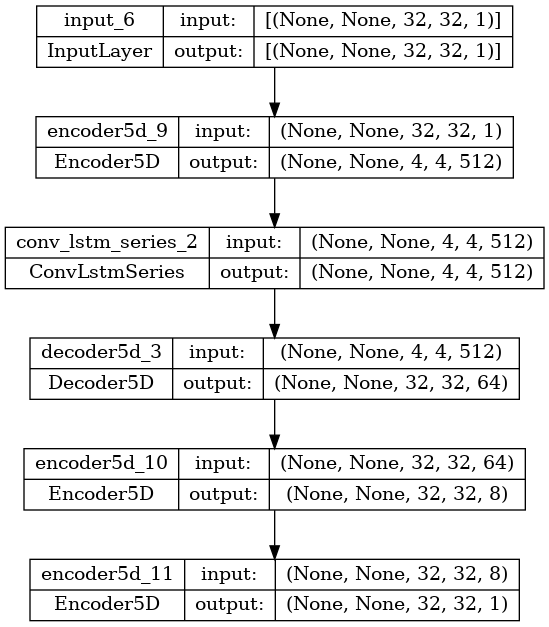

In [34]:
# encoder - lstms - decoder - retina(0) 모델을 생성.
enc_in_filters = 128
enc_conv_count = 3
lstm_count = 3
dec_conv_count = 3
retina_conv_count = 3

enc_out_filters = enc_in_filters*2**(enc_conv_count-1)
dec_in_filters = enc_out_filters // 2
retina_in_filters = dec_in_filters // 2**(dec_conv_count)
lstm_in_filters = enc_out_filters
if is_lstm_model:
    lstm_in_filters = 64
    
encoder = Encoder5D(enc_conv_count, enc_in_filters, (1, 3, 3), 2, "same")
decoder = Decoder5D(dec_conv_count, dec_in_filters, (1, 3, 3), 2, "same")

if is_lstm_model:
    lstms = ConvLstmSeries(lstm_in_filters, 1, [(3, 3), (3, 3), (3, 3)])
else:
    lstms = ConvLstmSeries(enc_out_filters, 0, [(3, 3), (3, 3), (3, 3)])

retina = Encoder5D(retina_conv_count, retina_in_filters, (1, 3, 3), 1, "same", out_channel=None)
retina0 = Encoder5D(0, 0, (1, 3, 3), 1, "same", out_channel=1)
# threshold_relu = ThresholdedReLU(theta=0.5)

inputs = layers.Input(shape=(None, img_w, img_h, 1))

if is_lstm_model:
    x = lstms(inputs)
    
elif is_autoenc_model:
    x = encoder(inputs)
    x = decoder(x)
    x = retina(x)
    x = retina0(x)

else:
    x = encoder(inputs)
    x = lstms(x)
    x = decoder(x)
    x = retina(x)
    x = retina0(x)

# x = threshold_relu(x)
outputs = x

model = Model(inputs=inputs, outputs=outputs, name='sketcher')
model.compile(optimizer = keras.optimizers.Adam(1e-4), loss = 'binary_crossentropy')
model.summary()

plot_model(model, show_shapes=True, expand_nested=True, show_dtype=False)

In [39]:
def save_all(prefix='base_200'):
    # model.save(os.path.join(cfg.MODEL_SAVE_PATH, f"sketcher_{prefix}"))
    encoder.save(os.path.join(cfg.MODEL_SAVE_PATH, f"enc_{prefix}"))
    lstms.save(os.path.join(cfg.MODEL_SAVE_PATH, f"lstm_{prefix}"))
    decoder.save(os.path.join(cfg.MODEL_SAVE_PATH, f"dec_{prefix}"))
    retina.save(os.path.join(cfg.MODEL_SAVE_PATH, f"retina_{prefix}"))
    retina0.save(os.path.join(cfg.MODEL_SAVE_PATH, f"retina0_{prefix}"))

In [40]:
def load_all(prefix='base_200'):
#     model = keras.models.load_model(os.path.join(cfg.MODEL_SAVE_PATH, f"sketcher_{prefix}"))
    encoder = keras.models.load_model(os.path.join(cfg.MODEL_SAVE_PATH, f"enc_{prefix}"))
    lstms = keras.models.load_model(os.path.join(cfg.MODEL_SAVE_PATH, f"lstm_{prefix}"))
    decoder = keras.models.load_model(os.path.join(cfg.MODEL_SAVE_PATH, f"dec_{prefix}"))
    retina = keras.models.load_model(os.path.join(cfg.MODEL_SAVE_PATH, f"retina_{prefix}"))
    retina0 = keras.models.load_model(os.path.join(cfg.MODEL_SAVE_PATH, f"retina0_{prefix}"))

In [42]:
load_all(prefix='base_400')

In [ ]:
# encoder.trainable = False
# decoder.trainable = False
# lstms.trainable = False
# retina.trainable = False
# retina0.trainable = False

In [37]:
epoch_cnt = 1
steps_per_epoch = 50
val_steps = 2

history = model.fit(
            tdgen,
            validation_data = vdgen,
            steps_per_epoch = steps_per_epoch,
            validation_steps = val_steps,
            epochs = epoch_cnt,
            batch_size = batch_size,
            verbose = 1,
        )

/home/evergrin/anaconda3/envs/pyenv_3912/lib/python3.9/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: CropAndPad could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
/home/evergrin/anaconda3/envs/pyenv_3912/lib/python3.9/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: SafeRotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(


1/1 [==============================] - 31s 31s/step - loss: 10.4668 - val_loss: 14.6864


In [ ]:
def plot_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()

In [41]:
save_all(prefix='base_400')

INFO:tensorflow:Assets written to: /home/evergrin/iu/datas/models/enc_base_400/assets


INFO:tensorflow:Assets written to: /home/evergrin/iu/datas/models/enc_base_400/assets


In [ ]:
plot_history(history)

In [ ]:
def arry5d_to_img(arry5d, save_as=''):
    frmimg_cnt = arry5d.shape[1]
    fig, axes = plt.subplots(nrows = 1, ncols = frmimg_cnt, figsize=(15, 3))

    for idx, num in enumerate(range(0, frmimg_cnt)):
        frm = ImgFrame(img=arry5d[0][idx][:, :, :], do_norm=False)
        img = frm.to_image()
        axes[idx].imshow(img, cmap='gray')

    plt.show()

In [ ]:
# dataset중 하나만 뽑아서 예측에 입력
it = iter(vdgen)
x, y = next(it)


In [ ]:
# x 이미지 한개 표시
arry5d_to_img(x)

In [ ]:
# y 이미지 한개 표시.
arry5d_to_img(y)

In [ ]:
# 예측하여 이미지 표시.
in_x = x[:1, :, :, :, :]
pred = model.predict(in_x)

file_name = os.path.join(cfg.TEMP_DATA_PATH, 'result.gif')
arry5d_to_img(pred, save_as=file_name)

In [ ]:
# user가 그린 임의의 그림 예측.
# user_file_name = os.path.join(cfg.TEMP_DATA_PATH, 'user_draw.gif')
# user_draw = VideoClip(gif_path=user_file_name)
# user_draw.resize(img_w, img_h, inplace=True)
# arry5d = user_draw.to_array(expand=True)
# print(arry5d.shape)
# arry5d_to_img(arry5d)

In [ ]:
# pred = model.predict(arry5d)

# file_name = os.path.join(cfg.TEMP_DATA_PATH, 'result.gif')
# arry5d_to_img(pred, save_as=file_name)